In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import os
from glob import glob

In [2]:
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt

DATA_FOLDER = 'C:/Users/pc/Desktop/road/512/'
SAVE_FOLDER = 'C:/Users/pc/Desktop/road'

train_img_list = np.array(glob(os.path.join(DATA_FOLDER + '*/*.jpg')))

In [3]:
INPUT_DIM = (128,128,3)
BATCH_SIZE = 32

NUM_IMAGES = len(train_img_list)
print(NUM_IMAGES)

mode =  'build'

1186


In [4]:
data_gen = ImageDataGenerator(rescale=1./255)

data_flow = data_gen.flow_from_directory(DATA_FOLDER
                                         , target_size = INPUT_DIM[:2]
                                         , batch_size = BATCH_SIZE
                                         , shuffle = True
                                         , class_mode = 'input'
                                         , subset = "training"
                                            )

Found 1186 images belonging to 1 classes.


In [5]:
class Sampling(layers.Layer):
    """Uses (mu, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mu, log_var = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(log_var/2) * epsilon

In [6]:
z_dim = 200
r_loss_factor = 10000

# encoder model definition

encoder_input = keras.Input(shape=INPUT_DIM, name='encoder_input')
x = Conv2D(32, 3, strides=2, padding="same", name='encoder_conv_0')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_1')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_3')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
mu = Dense(z_dim, name='mu')(x)
log_var = Dense(z_dim, name='log_var')(x)
z = Sampling(name='encoder_output')([mu, log_var])
encoder = keras.Model(encoder_input, [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 32)   896         ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['encoder_conv_0[0][0]']         
 alization)                                                                                       
                                                                                            

In [7]:
# decoder model definition

decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t0')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t1')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", name='decoder_conv_t2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(3, 3, strides=2, padding="same", name='decoder_conv_t3')(x)
decoder_output = Activation('sigmoid')(x)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 4096)              823296    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 decoder_conv_t0 (Conv2DTran  (None, 16, 16, 64)       36928     
 spose)                                                          
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0   

In [8]:
# Variational Autoencoder model definition

class VAEModel(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        #self.r_loss_factor = r_loss_factor

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                #tf.square(data - reconstruction)
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= r_loss_factor
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": tf.reduce_mean(total_loss),
            "reconstruction_loss": tf.reduce_mean(reconstruction_loss),
            "kl_loss": tf.reduce_mean(kl_loss),
        }

    def call(self,inputs):
        _,_,latent = self.encoder(inputs)
        return self.decoder(latent)

In [9]:
LEARNING_RATE = 0.0005
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 10
INITIAL_EPOCH = 0

save_folder = os.path.join(SAVE_FOLDER, 'weights')

VAE = VAEModel(encoder, decoder)
VAE.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

In [10]:
MODE = 'build'
#MODE = 'load'

if MODE == 'load':
    #ae = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})
    VAE.load_weights(save_folder+'/'+'checkpoint')

In [11]:
# train

def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        return new_lr

    return LearningRateScheduler(schedule)

checkpoint = ModelCheckpoint(save_folder+'/'+'checkpoint', save_weights_only = True, verbose=1)
lr_sched = step_decay_schedule(initial_lr=LEARNING_RATE, decay_factor=1, step_size=1)
callbacks_list = [checkpoint, lr_sched]

VAE.fit(
    data_flow,
    shuffle=True,
    epochs=EPOCHS,
    steps_per_epoch = NUM_IMAGES / BATCH_SIZE,
    callbacks=callbacks_list
)

Epoch 1/100
38/37 [==============================] - ETA: 0s - loss: 6853.0920 - reconstruction_loss: 6847.2048 - kl_loss: 5.8871
Epoch 1: saving model to C:/Users/pc/Desktop/road\weights\checkpoint
37/37 [==============================] - 9s 202ms/step - loss: 6846.7262 - reconstruction_loss: 6840.6168 - kl_loss: 6.1094 - lr: 5.0000e-04
Epoch 2/100
38/37 [==============================] - ETA: 0s - loss: 6532.0147 - reconstruction_loss: 6511.9358 - kl_loss: 20.0789
Epoch 2: saving model to C:/Users/pc/Desktop/road\weights\checkpoint
37/37 [==============================] - 6s 160ms/step - loss: 6532.8035 - reconstruction_loss: 6512.7761 - kl_loss: 20.0275 - lr: 5.0000e-04
Epoch 3/100
38/37 [==============================] - ETA: 0s - loss: 6410.4602 - reconstruction_loss: 6391.4259 - kl_loss: 19.0344
Epoch 3: saving model to C:/Users/pc/Desktop/road\weights\checkpoint
37/37 [==============================] - 6s 163ms/step - loss: 6407.5951 - reconstruction_loss: 6388.5723 - kl_loss: 1

Epoch 25/100
38/37 [==============================] - ETA: 0s - loss: 6413.8276 - reconstruction_loss: 6398.0239 - kl_loss: 15.8038
Epoch 25: saving model to C:/Users/pc/Desktop/road\weights\checkpoint
37/37 [==============================] - 5s 141ms/step - loss: 6412.3536 - reconstruction_loss: 6396.5354 - kl_loss: 15.8182 - lr: 5.0000e-04
Epoch 26/100
38/37 [==============================] - ETA: 0s - loss: 6405.1198 - reconstruction_loss: 6389.2900 - kl_loss: 15.8297
Epoch 26: saving model to C:/Users/pc/Desktop/road\weights\checkpoint
37/37 [==============================] - 5s 146ms/step - loss: 6406.9285 - reconstruction_loss: 6391.1623 - kl_loss: 15.7662 - lr: 5.0000e-04
Epoch 27/100
38/37 [==============================] - ETA: 0s - loss: 6407.3582 - reconstruction_loss: 6391.9781 - kl_loss: 15.3801
Epoch 27: saving model to C:/Users/pc/Desktop/road\weights\checkpoint
37/37 [==============================] - 6s 149ms/step - loss: 6406.2300 - reconstruction_loss: 6390.8727 - kl

Epoch 49/100
38/37 [==============================] - ETA: 0s - loss: 6360.0571 - reconstruction_loss: 6350.0975 - kl_loss: 9.9596
Epoch 49: saving model to C:/Users/pc/Desktop/road\weights\checkpoint
37/37 [==============================] - 6s 149ms/step - loss: 6362.4514 - reconstruction_loss: 6352.4949 - kl_loss: 9.9566 - lr: 5.0000e-04
Epoch 50/100
38/37 [==============================] - ETA: 0s - loss: 6383.3633 - reconstruction_loss: 6373.6182 - kl_loss: 9.7451
Epoch 50: saving model to C:/Users/pc/Desktop/road\weights\checkpoint
37/37 [==============================] - 6s 159ms/step - loss: 6380.1874 - reconstruction_loss: 6370.4112 - kl_loss: 9.7763 - lr: 5.0000e-04
Epoch 51/100
38/37 [==============================] - ETA: 0s - loss: 6365.0014 - reconstruction_loss: 6355.3879 - kl_loss: 9.6135
Epoch 51: saving model to C:/Users/pc/Desktop/road\weights\checkpoint
37/37 [==============================] - 6s 150ms/step - loss: 6367.6836 - reconstruction_loss: 6358.0909 - kl_loss

Epoch 73/100
38/37 [==============================] - ETA: 0s - loss: 6370.2695 - reconstruction_loss: 6361.9853 - kl_loss: 8.2841
Epoch 73: saving model to C:/Users/pc/Desktop/road\weights\checkpoint
37/37 [==============================] - 5s 138ms/step - loss: 6371.5740 - reconstruction_loss: 6363.2774 - kl_loss: 8.2966 - lr: 5.0000e-04
Epoch 74/100
38/37 [==============================] - ETA: 0s - loss: 6364.7440 - reconstruction_loss: 6356.3294 - kl_loss: 8.4145
Epoch 74: saving model to C:/Users/pc/Desktop/road\weights\checkpoint
37/37 [==============================] - 6s 162ms/step - loss: 6360.7954 - reconstruction_loss: 6352.3713 - kl_loss: 8.4241 - lr: 5.0000e-04
Epoch 75/100
38/37 [==============================] - ETA: 0s - loss: 6388.0817 - reconstruction_loss: 6379.8332 - kl_loss: 8.2486
Epoch 75: saving model to C:/Users/pc/Desktop/road\weights\checkpoint
37/37 [==============================] - 6s 161ms/step - loss: 6384.7570 - reconstruction_loss: 6376.5003 - kl_loss

Epoch 97/100
38/37 [==============================] - ETA: 0s - loss: 6384.5811 - reconstruction_loss: 6376.3275 - kl_loss: 8.2535
Epoch 97: saving model to C:/Users/pc/Desktop/road\weights\checkpoint
37/37 [==============================] - 5s 146ms/step - loss: 6387.0137 - reconstruction_loss: 6378.7761 - kl_loss: 8.2375 - lr: 5.0000e-04
Epoch 98/100
38/37 [==============================] - ETA: 0s - loss: 6370.5973 - reconstruction_loss: 6362.4000 - kl_loss: 8.1973
Epoch 98: saving model to C:/Users/pc/Desktop/road\weights\checkpoint
37/37 [==============================] - 6s 149ms/step - loss: 6367.8696 - reconstruction_loss: 6359.6491 - kl_loss: 8.2205 - lr: 5.0000e-04
Epoch 99/100
38/37 [==============================] - ETA: 0s - loss: 6337.4622 - reconstruction_loss: 6329.1714 - kl_loss: 8.2908
Epoch 99: saving model to C:/Users/pc/Desktop/road\weights\checkpoint
37/37 [==============================] - 5s 141ms/step - loss: 6342.5196 - reconstruction_loss: 6334.2519 - kl_loss

In [15]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

x = np.random.rand(1,128,128,3)
VAE.predict(x)
#VAE.save(save_folder)
tf.saved_model.save(VAE, save_folder)

1/1 [==============================] - 0s 16ms/step
INFO:tensorflow:Assets written to: C:/Users/pc/Desktop/road\weights\assets


INFO:tensorflow:Assets written to: C:/Users/pc/Desktop/road\weights\assets


In [12]:
VAE.load_weights('C:/Users/pc/Desktop/road/weights/checkpoint')

1/1 [==============================] - 1s 683ms/step


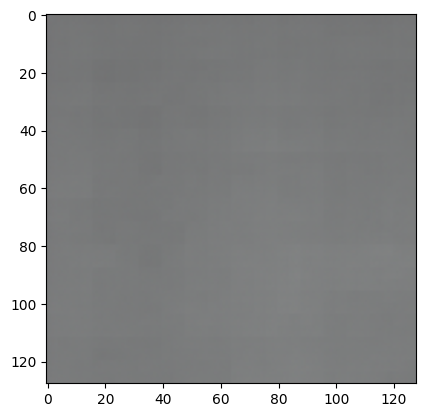

In [13]:
x = np.random.rand(1,128,128,3)
#plt.imshow(x[0])
plt.imshow(VAE.predict(x)[0])